# Copyright Netherlands eScience Center <br>
** Function     : Predict the Spatial Sea Ice Concentration with ConvLSTM at weekly time scale** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.05.21 ** <br>
** Last Update  : 2019.05.21 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, deepclim, matplotlib <br>
Description     : This notebook serves to predict the Arctic sea ice using deep learning. We also include many climate index (to represent the forcing from atmosphere). The convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>

Return Values   : Time series and figures <br>

Here is the information of climate index in details:<br>
**NAO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml <br>
**ENSO - NINO 3.4 SST** @ 1950 Jan - 2018 Jan (817 records) <br>
https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/ <br>
**AO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao.shtml <br>
**AMO** @ 1950 Jan - 2018 Feb (818 records) <br>
AMO unsmoothed, detrended from the Kaplan SST V2. The result is standarised.<br>
https://www.esrl.noaa.gov/psd/data/timeseries/AMO/<br>

(All the NOAA index shown above are given by NCEP/NCAR Reanalysis (CDAS))<br>

**PDO** @ 1900 Jan - 2018 Feb (1418 records)<br>
This PDO index comes from University of Washington, it contains SST data from the following 3 datasets:<br>
- UKMO Historical SST data set for 1900-81;
- Reynold's Optimally Interpolated SST (V1) for January 1982-Dec 2001)
- OI SST Version 2 (V2) beginning January 2002 -<br>

http://research.jisao.washington.edu/pdo/PDO.latest<br>

The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [2]:
%matplotlib inline

import sys

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DeepClim'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DeepClim")
import deepclim
import deepclim.preprocess
import deepclim.deepSeries
import deepclim.deepArray
#import deepclim.deepArrayStep
#import deepclim.function

# for visualization
import deepclim.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [1]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)
- **ORAS4**       1958 - 2014 (ECMWF)

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>


Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [4]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
#datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
datapath_ERAI = 'F:\\PhD_essential\\Core_Database_DeepLearn\\ERA-Interim'
#datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
datapath_ORAS4 = 'F:\\PhD_essential\\Core_Database_DeepLearn\\ORAS4'
#datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_ORAS4_mask = 'F:\\PhD_essential\\Core_Database_DeepLearn\\ORAS4'
#datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
datapath_PIOMASS = 'F:\\PhD_essential\\Core_Database_AMET_OMET_reanalysis\\PIOMASS'
#datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
datapath_clim_index = 'F:\\PhD_essential\\Core_Database_AMET_OMET_reanalysis\\Climate_index'
#output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Maps'
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\Maps'

In [7]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    # weekly variables on ERAI grid
    dataset_ERAI_fields_sic = Dataset(os.path.join(datapath_ERAI,
                                      'sic_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_slp = Dataset(os.path.join(datapath_ERAI,
                                      'slp_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_t2m = Dataset(os.path.join(datapath_ERAI,
                                      't2m_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_z500 = Dataset(os.path.join(datapath_ERAI,
                                       'z500_weekly_erai_1979_2017.nc'))    
    #dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
    #                             'siv_monthly_PIOMASS_1979_2017.nc'))
    # OHC interpolated on ERA-Interim grid
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                'ohc_monthly_oras2erai_1978_2017.nc'))
    dataset_index = Dataset(os.path.join(datapath_clim_index,
                            'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2013
    # validation: 2014 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim) - benckmark
    SIC_ERAI = dataset_ERAI_fields_sic.variables['sic'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI = dataset_ERAI_fields_sic.variables['year'][:-1]
    week_ERAI = dataset_ERAI_fields_sic.variables['week'][:]
    latitude_ERAI = dataset_ERAI_fields_sic.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_sic.variables['longitude'][:]
    # T2M (ERA-Interim)
    T2M_ERAI = dataset_ERAI_fields_t2m.variables['t2m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_t2m = dataset_ERAI_fields_t2m.variables['year'][:-1]
    week_ERAI_t2m = dataset_ERAI_fields_t2m.variables['week'][:]
    latitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['latitude'][:]
    longitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['longitude'][:]
    #SIV (PIOMASS)
    #SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    #year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # OHC (ORAS4)
    # from 1978 - 2017 (for interpolation) / from 90 N upto 40 N
    OHC_300_ORAS4 = dataset_ORAS4_OHC.variables['OHC'][:-1,:,:67,:]/1000 # unit Peta Joule
    latitude_ORAS4 = dataset_ORAS4_OHC.variables['latitude'][:]
    longitude_ORAS4 = dataset_ORAS4_OHC.variables['longitude'][:]
    mask_OHC = np.ma.getmask(OHC_300_ORAS4[0,0,:,:])
    # AO-NAO-AMO-NINO3.4 (NOAA)
    AO = dataset_index.variables['AO'][348:-1] # from 1979 - 2017
    NAO = dataset_index.variables['NAO'][348:-1]
    NINO = dataset_index.variables['NINO'][348:-1]
    AMO = dataset_index.variables['AMO'][348:-1]
    PDO = dataset_index.variables['PDO'][348:-1]

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [9]:
    # first check of grid
    print(latitude_ERAI)
    print(longitude_ERAI)
    print(latitude_ERAI_t2m)
    print(longitude_ERAI_t2m)
    print(longitude_ORAS4)

[89.5  88.75 88.   87.25 86.5  85.75 85.   84.25 83.5  82.75 82.   81.25
 80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25
 62.5  61.75 61.   60.25 59.5  58.75 58.   57.25 56.5  55.75 55.   54.25
 53.5  52.75 52.   51.25 50.5  49.75 49.   48.25 47.5  46.75 46.   45.25
 44.5  43.75 43.   42.25 41.5  40.75 40.  ]
[-180.   -179.25 -178.5  -177.75 -177.   -176.25 -175.5  -174.75 -174.
 -173.25 -172.5  -171.75 -171.   -170.25 -169.5  -168.75 -168.   -167.25
 -166.5  -165.75 -165.   -164.25 -163.5  -162.75 -162.   -161.25 -160.5
 -159.75 -159.   -158.25 -157.5  -156.75 -156.   -155.25 -154.5  -153.75
 -153.   -152.25 -151.5  -150.75 -150.   -149.25 -148.5  -147.75 -147.
 -146.25 -145.5  -144.75 -144.   -143.25 -142.5  -141.75 -141.   -140.25
 -139.5  -138.75 -138.   -137.25 -136.5  -135.75 -135.   -134.25 -133.5
 -132.75 -132.   -131.25 -130.5  -129.75 -129.   -128.25 -127.5  -126.75
 -126.   -125

In [10]:
    #################################################################################
    ###########                regionalization sea mask                   ###########
    #################################################################################
    print ('*********************** create mask *************************')
    # W:-156 E:-124 N:80 S:67
    mask_Beaufort = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:-156 N:80 S:66
    mask_Chukchi = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:146 E:180 N:80 S:67
    mask_EastSiberian = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:100 E:146 N:80 S:67
    mask_Laptev = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:60 E:100 N:80 S:67
    mask_Kara = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:18 E:60 N:80 S:64
    mask_Barents = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-44 E:18 N:80 S:55
    mask_Greenland = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:180 N:90 S:80
    mask_CenArctic = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    print ('*********************** calc mask *************************')
    mask_Beaufort[13:31,32:76] = 1

    mask_Chukchi[13:32,0:32] = 1
    mask_Chukchi[13:32,-1] = 1

    mask_EastSiberian[13:31,434:479] = 1

    mask_Laptev[13:31,374:434] = 1

    mask_Kara[13:31,320:374] = 1

    mask_Barents[13:36,264:320] = 1

    mask_Greenland[13:47,179:264] = 1
    mask_Greenland[26:47,240:264] = 0

    mask_CenArctic[:13,:] = 1
    print ('*********************** packing *************************')
    mask_dict = {'Beaufort': mask_Beaufort[:,:],
                 'Chukchi': mask_Chukchi[:,:],
                 'EastSiberian': mask_EastSiberian[:,:],
                 'Laptev': mask_Laptev[:,:],
                 'Kara': mask_Kara[:,:],
                 'Barents': mask_Barents[:,:],
                 'Greenland': mask_Greenland[:,:],
                 'CenArctic': mask_CenArctic[:,:]}
    seas_namelist = ['Beaufort','Chukchi','EastSiberian','Laptev',
                     'Kara', 'Barents', 'Greenland','CenArctic']

*********************** create mask *************************
*********************** calc mask *************************
*********************** packing *************************


In [11]:
    #################################################################################
    ########                  temporal interpolation matrix                  ########
    #################################################################################
    # interpolate from monthly to weekly
    # original monthly data will be taken as the last week of the month
    OHC_300_ORAS4_weekly_series = np.zeros(SIC_ERAI.reshape(len(year_ERAI)*48,len(latitude_ERAI),len(longitude_ERAI)).shape,
                                           dtype=float)
    OHC_300_ORAS4_series= deepclim.preprocess.operator.unfold(OHC_300_ORAS4)
    # calculate the difference between two months
    OHC_300_ORAS4_deviation_series = (OHC_300_ORAS4_series[1:,:,:] - OHC_300_ORAS4_series[:-1,:,:]) / 4
    for i in np.arange(4):
        OHC_300_ORAS4_weekly_series[3-i::4,:,:] = OHC_300_ORAS4_series[12:,:,:] - i * OHC_300_ORAS4_deviation_series[11:,:,:]

In [12]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / 480
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:])):
        # change the unit to terawatt
        SIC_ERAI_area[:,:,i,:] = SIC_ERAI[:,:,i,:]* dx[i] * dy / 1E+6 # unit km2
    SIC_ERAI_area[SIC_ERAI_area<0] = 0 # switch the mask from -1 to 0
    print ('================  reshape input data into time series  =================')
    SIC_ERAI_area_series = deepclim.preprocess.operator.unfold(SIC_ERAI_area)
    T2M_ERAI_series = deepclim.preprocess.operator.unfold(T2M_ERAI)

******************  calculate extent from spatial fields  *******************
================  reshape input data into time series  =================


In [13]:
    print ('******************  choose the fields from target region  *******************')
    # select the area between greenland and ice land for instance 60-70 N / 44-18 W
    sic_exp = SIC_ERAI_area_series[:,12:36,264:320]
    t2m_exp = T2M_ERAI_series[:,12:36,264:320]
    ohc_exp = OHC_300_ORAS4_weekly_series[:,12:36,264:320]
    print(sic_exp.shape)
    print(t2m_exp.shape)
    print(ohc_exp.shape)
    print(latitude_ERAI[12:36])
    print(longitude_ERAI[264:320])
    print(latitude_ORAS4[12:36])
    print(longitude_ORAS4[264:320])
    #print(latitude_ERAI[26:40])
    #print(longitude_ERAI[180:216])

******************  choose the fields from target region  *******************
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   39.75 40.5  41.25 42.   42.75 43.5  44.25
 45.   45.75 46.5  47.25 48.   48.75 49.5  50.25 51.   51.75 52.5  53.25
 54.   54.75 55.5  56.25 57.   57.75 58.5  59.25]
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   39.75 40.5  41.25 42.   42.75 43.5  44.25
 45.   45.75 46.5  47.

In [14]:
    print ('*******************  pre-processing  *********************')
    print ('=========================   normalize data   ===========================')
    sic_exp_norm = deepclim.preprocess.operator.normalize(sic_exp)
    t2m_exp_norm = deepclim.preprocess.operator.normalize(t2m_exp)
    ohc_exp_norm = deepclim.preprocess.operator.normalize(ohc_exp)
    _, yy, xx = sic_exp_norm.shape # get the lat lon dimension for 
    print ('====================    A series of time (index)    ====================')
    year = np.arange(1979,2017,1)
    year_cycle = np.repeat(year,48)
    month_cycle = np.repeat(np.arange(1,13,1),4)
    month_cycle = np.tile(month_cycle,len(year)+1) # one extra repeat for lead time dependent prediction
    month_cycle.astype(float)
    month_2D = np.repeat(month_cycle[:,np.newaxis],yy,1)
    month_exp = np.repeat(month_2D[:,:,np.newaxis],xx,2)
    print ('===================  artificial data for evaluation ====================')
    # calculate climatology of SIC
#     seansonal_cycle_SIC = np.zeros(48,dtype=float)
#     for i in np.arange(48):
#         seansonal_cycle_SIC[i] = np.mean(SIC_ERAI_sum_norm[i::48],axis=0)
    # weight for loss
#     weight_month = np.array([0,1,1,
#                              1,0,0,
#                              1,1,1,
#                              0,0,0])
    #weight_loss = np.repeat(weight_month,4)
    #weight_loss = np.tile(weight_loss,len(year))

*******************  pre-processing  *********************
=========================   normalize data   ===========================
====================    A series of time (index)    ====================
===================  artificial data for evaluation ====================


(1824, 24, 56)
[[251.4346045  251.05600413 250.50871172 ... 244.2139345  244.13173904
  244.01692955]
 [246.64799721 246.04600942 245.45885542 ... 245.36829478 245.24715214
  245.12353721]
 [246.7402512  247.31849816 248.16998491 ... 246.47754407 246.37387686
  246.26773736]
 ...
 [271.39089775 271.56084288 271.75937185 ... 272.40565781 271.30805881
  270.25455477]
 [271.93968032 272.07067828 272.09157428 ... 273.35488503 272.4173081
  271.39831464]
 [272.82825155 272.92514534 272.69329114 ... 274.15672261 273.34753587
  272.70551716]]
(24, 56)


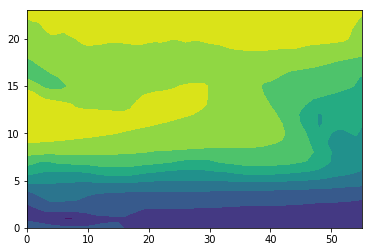

In [16]:
    print(t2m_exp.shape)
    ax = plt.contourf(t2m_exp[443,:,:])
    print(t2m_exp[443,:,:])
    print(month_exp[0,:,:].shape)

In [17]:
    x_input = np.stack((sic_exp_norm[1,:,:],
                        t2m_exp_norm[1,:,:],
                        ohc_exp_norm[1,:,:],
                        month_exp[1,:,:]))
    print(x_input[1,:,:])
    print(x_input[:].shape)

[[0.26267704 0.26046318 0.25661401 ... 0.22950646 0.22708498 0.22442972]
 [0.20302922 0.20179229 0.20073181 ... 0.23818486 0.23636252 0.23451899]
 [0.19524795 0.20810658 0.22415041 ... 0.25322432 0.25219251 0.25112267]
 ...
 [0.48474634 0.48954066 0.49081374 ... 0.36213768 0.336037   0.3028926 ]
 [0.49387301 0.5059012  0.52108218 ... 0.37193518 0.34423099 0.31239209]
 [0.52729484 0.54777388 0.5776589  ... 0.38700331 0.35481465 0.32946398]]
(4, 24, 56)


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [10]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 4
    hidden_channels = [4, 4, 3] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [3, 3, 3, 3, 2]
    #hidden_channels = [2]
    kernel_size = 3
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.01
    num_epochs = 1500
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    print ('*******************  cross validation and testing data  *********************')
    # take 10% data as cross-validation data
    cross_valid_year = 4
    # take 10% years as testing data
    test_year = 4
    # minibatch
    #iterations = 3 # training data divided into 3 sets

*******************  create basic dimensions for tensor and network  *********************
1.1.0
Is CUDA available? True


In [13]:
    print ('*******************  preview of input tensor  *********************')
    #plt.plot(SIC_ERAI_sum)
    #print(SIC_ERAI_sum_norm[:-test_year*12])
    #print(x_input.shape)
    #print(x_input[:,:,:])
    sequence_len, _, _ = sic_exp_norm.shape
    print(sequence_len)

*******************  preview of input tensor  *********************
1824


In [ ]:
#     print ('*******************  module for calculating accuracy  *********************')
#     def accuracy(out, labels):
#         outputs = np.argmax(out, axis=1)
#     return np.sum(outputs==labels)/float(labels.size)

In [14]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    model = torch.load(os.path.join(output_path, 'Barents','convlstm_era_sic_oras_ohc_Barents_hl_5_kernel_3_lr_0.01_epoch_1500.pkl'))
    print(model)
     # check the sequence length (dimension in need for post-processing)
    sequence_len, height, width = sic_exp_norm.shape

*******************  load exsited LSTM model  *********************
ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1),

In [11]:
    %%time
    print ('*******************  run LSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence length
    sequence_len, height, width = sic_exp_norm.shape

    # initialize our model
    model = deepclim.deepArray.ConvLSTM(input_channels, hidden_channels, kernel_size).cuda()
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - test_year*12*4):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((sic_exp_norm[timestep,:,:],
                                ohc_exp_norm[timestep,:,:],
                                month_exp[timestep,:,:])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).cuda()
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = np.stack((sic_exp_norm[timestep+1,:,:],
                                      ohc_exp_norm[timestep+1,:,:],)) #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).cuda()
            #################################################################################   
            # Forward pass
            y_pred, _ = model(x_var, timestep)
            # choose training data
            y_train = y_var        
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss = loss_fn(y_pred, y_train)
            else:
                loss += loss_fn(y_pred, y_train)
            #print (timestep)
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 10 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
            #print(y_pred)
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    torch.save(model, os.path.join(output_path,'convlstm.pkl')) # save lstm model

*******************  run LSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.


G:\Anaconda\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(3, 3, kernel_size=(3, 3), stride=

Epoch  1630 MSE:  1.9236112833023071
Epoch  1640 MSE:  1.8593560457229614
Epoch  1650 MSE:  1.8410944938659668
Epoch  1660 MSE:  1.8310645818710327
Epoch  1670 MSE:  1.828477382659912
Epoch  1680 MSE:  1.8244208097457886
Epoch  1690 MSE:  2.3282129764556885
Epoch  1700 MSE:  1.978827714920044
Epoch  1710 MSE:  1.9063862562179565
Epoch  1720 MSE:  1.837782621383667
Epoch  1730 MSE:  1.8056209087371826
Epoch  1740 MSE:  1.8010276556015015
Epoch  1750 MSE:  1.7973817586898804
Epoch  1760 MSE:  1.7928684949874878
Epoch  1770 MSE:  1.809282660484314
Epoch  1780 MSE:  1.849301815032959
Epoch  1790 MSE:  1.87237548828125
Epoch  1800 MSE:  1.7930104732513428
Epoch  1810 MSE:  1.7928736209869385
Epoch  1820 MSE:  1.8670493364334106
Epoch  1830 MSE:  1.8654049634933472
Epoch  1840 MSE:  1.7935874462127686
Epoch  1850 MSE:  1.7801307439804077
Epoch  1860 MSE:  1.79450523853302
Epoch  1870 MSE:  1.766912817955017
Epoch  1880 MSE:  1.769433617591858
Epoch  1890 MSE:  2.082158327102661
Epoch  1900 M

In [12]:
print(y_pred.shape)
#print(y_pred[0,0,:,:])
print(y_train.shape)
#print(model.cell0.Wcf)
#print(sic_exp_norm[:-test_year*12*4].shape)
#print(sic_exp_norm[:2,:,:])
#print(sic_exp_norm[:2,:,:].shape)
#kkk = np.vstack((sic_exp_norm[:2,:,:],y_pred[0,0,:,:].cpu().data.numpy().reshape(-1,height,width)))
#print(kkk)
#print(model.internal_state[0])#.data.numpy().shape)

torch.Size([1, 2, 24, 56])
torch.Size([1, 2, 24, 56])


In [12]:
    %%time
    #################################################################################
    ########            fully leading prediction for a first-check           ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(test_year))
    # time series before test data
    pred_base_sic = sic_exp_norm[:-test_year*12*4,:,:]
    pred_base_ohc = ohc_exp_norm[:-test_year*12*4,:,:]
    # prediction validation with training data
    pred_fake_sic = sic_exp_norm[0,:,:].reshape(-1,height,width)
    pred_fake_ohc = ohc_exp_norm[0,:,:].reshape(-1,height,width)
    
    for i in np.arange(1,sequence_len,1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
        # Clear stored gradient
        if i == 1:
            model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        #model.hidden = model.init_hidden()
        # based on the design of this module, the hidden states and cell states are initialized when the module is called.
        #############################################################################
        ###############           before time of prediction           ###############
        #############################################################################
        if i <= (sequence_len-test_year*12*4):
            # create variables
            x_input = np.stack((sic_exp_norm[i-1,:,:],
                                ohc_exp_norm[i-1,:,:],
                                month_exp[i-1,:,:])) #vstack,hstack,dstack
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                 requires_grad=False).cuda()
            # make prediction
            last_pred, _ = model(x_var_pred, i-1)
            # save the predicted data for validation (GPU data should be transferred to CPU)
            pred_fake_sic = np.vstack((pred_fake_sic[:,:,:],last_pred[0,0,:,:].cpu().data.numpy().reshape(-1,height,width)))
            pred_fake_ohc = np.vstack((pred_fake_ohc[:,:,:],last_pred[0,1,:,:].cpu().data.numpy().reshape(-1,height,width)))
            # record the real prediction after the time of prediction
            if i == (sequence_len-test_year*12*4):
                # GPU data should be transferred to CPU
                data_predict_sic = last_pred[0,0,:,:].cpu().data.numpy().reshape(-1,height,width)
                data_predict_ohc = last_pred[0,1,:,:].cpu().data.numpy().reshape(-1,height,width)
        #############################################################################
        ###############            after time of prediction           ###############
        #############################################################################
        else:
            # prepare predictor
            # use the predicted data to make new prediction
            x_input = np.stack((data_predict_sic[i-(sequence_len-test_year*12*4+1),:,:],
                                data_predict_ohc[i-(sequence_len-test_year*12*4+1),:,:],
                                month_exp[i-1,:,:])) #vstack,hstack,dstack
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                 requires_grad=False).cuda()        
            # make prediction
            last_pred, _ = model(x_var_pred, i-1)
            # record the prediction
            data_predict_sic = np.vstack((data_predict_sic[:,:,:],last_pred[0,0,:,:].cpu().data.numpy().reshape(-1,height,width)))
            data_predict_ohc = np.vstack((data_predict_ohc[:,:,:],last_pred[0,1,:,:].cpu().data.numpy().reshape(-1,height,width)))

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 3 years of total time series are treated as test data  ************
Wall time: 24.8 s


In [25]:
print(sequence_len-test_year*12*4)
print(i)
print(sequence_len)
print(month_exp.shape)

1680
1823
1824
(1824, 8, 16)


In [13]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        """
        rmse = np.sqrt(np.mean((x-y)**2,0))
    
        return rmse
    
    def RSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        """
        rmse = np.sqrt((x-y)**2)
    
        return rmse    

*******************  evaluation matrix  *********************


*******************  verification  **********************


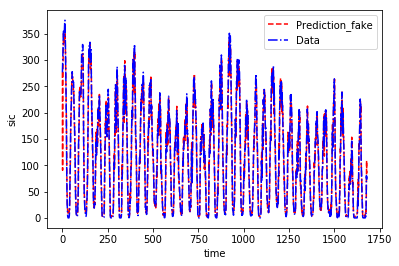

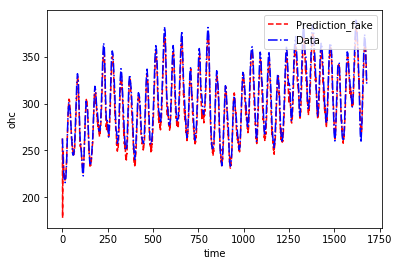

*******************  Predicted Ice Extent  **********************


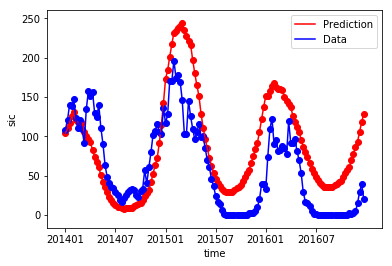

*******************  Predicted total OHC  **********************


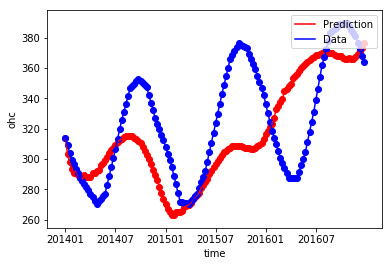

*******************  Loss with time  **********************


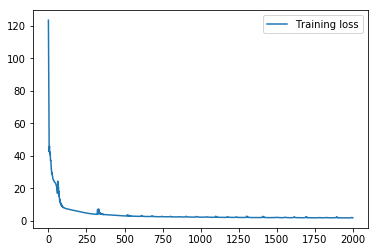

*******************  Prediction Ice Distribution  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


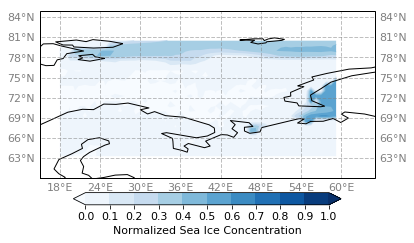

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


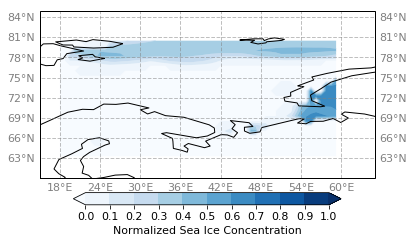

*******************  Other variables (Prediction with testing sets only) **********************


In [14]:
    #################################################################################
    ########           visualization of fully leading prediction             ########
    #################################################################################
    index_plot = np.arange(test_year*12*4)
    year_index = np.arange(2014,2017,1)
    # repeat climatology as reference
    #climatology = np.tile(seansonal_cycle_SIC,len(year_ERAI))
    # create index
    print ("*******************  verification  **********************")
    fig00 = plt.figure()
    plt.plot(np.arange(sequence_len-test_year*12*4), np.sum(np.sum(pred_fake_sic[:-1,:,:],2),1), 'r--',label="Prediction_fake")
    plt.plot(np.arange(sequence_len-test_year*12*4), np.sum(np.sum(sic_exp_norm[:-test_year*12*4,:,:],2),1), 'b-.',label="Data")
    plt.xlabel('time')
    plt.ylabel('sic')
    plt.legend(loc=1)
    plt.show()
    fig00.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_verify_check.png'),dpi=300)

    fig01 = plt.figure()
    plt.plot(np.arange(sequence_len-test_year*12*4), np.sum(np.sum(pred_fake_ohc[:-1,:,:],2),1), 'r--',label="Prediction_fake")
    plt.plot(np.arange(sequence_len-test_year*12*4), np.sum(np.sum(ohc_exp_norm[:-test_year*12*4,:,:],2),1), 'b-.',label="Data")
    plt.xlabel('time')
    plt.ylabel('ohc')
    plt.legend(loc=1)
    plt.show()
    fig01.savefig(os.path.join(output_path, 'OHC_ERAI_LSTM_verify_check.png'),dpi=300)
    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    fig0 = plt.figure()
    plt.plot(index_plot, np.sum(np.sum(data_predict_sic,2),1), 'r',label="Prediction")
    plt.scatter(index_plot, np.sum(np.sum(data_predict_sic,2),1), color='r')
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1), 'b',label="Data")
    plt.scatter(index_plot,np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1),color='b')
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('time')
    plt.ylabel('sic')
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201401', '201407',  '201501', '201507', '201601', '201607']))
    plt.legend(loc=1)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_check.png'),dpi=300)
    print ("*******************  Predicted total OHC  **********************")
    fig1 = plt.figure()
    plt.plot(index_plot, np.sum(np.sum(data_predict_ohc,2),1), 'r',label="Prediction")
    plt.scatter(index_plot, np.sum(np.sum(data_predict_ohc,2),1), color='r')
    plt.plot(index_plot, np.sum(np.sum(ohc_exp_norm[-test_year*12*4:,:,:],2),1), 'b',label="Data")
    plt.scatter(index_plot,np.sum(np.sum(ohc_exp_norm[-test_year*12*4:,:,:],2),1),color='b')
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('time')
    plt.ylabel('ohc')
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201401', '201407',  '201501', '201507', '201601', '201607']))
    plt.legend(loc=1)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig1.savefig(os.path.join(output_path,'OHC_ERAI_LSTM_pred_check.png'),dpi=300)    
    
    print ("*******************  Loss with time  **********************")
    fig2 = plt.figure()
    try:
        plt.plot(hist, label="Training loss")
        plt.legend()
        plt.show()
        fig2.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_error.png'),dpi=300)
    except:
        print('Model is reloaded instead of trained!')
    
    print ("*******************  Prediction Ice Distribution  **********************")
    label = 'Normalized Sea Ice Concentration'
    ticks = [i for i in np.linspace(0,1.0,11)]
    p = None # no t-test
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   data_predict_sic[0,:,:], p, # np.ma.masked_where(mask_SIC[12:36,264:320],data_predict_sic[0,:,:])
                                   label, ticks, os.path.join(output_path,
                                   'spatial_sic_week_1_pred.png'), boundary='Barents',
                                   colormap='Blues')
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   sic_exp_norm[sequence_len-test_year*12*4,:,:], p, # np.ma.masked_where(mask_SIC[12:36,264:320],data_predict_sic[0,:,:])
                                   label, ticks, os.path.join(output_path,
                                   'spatial_sic_week_1_truth.png'), boundary='Barents',
                                   colormap='Blues')    
    print ("*******************  Other variables (Prediction with testing sets only) **********************")

In [15]:
    %%time
    #################################################################################
    ########            operational lead time dependent prediction           ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(test_year))
    # time series before test data
    pred_base_sic = sic_exp_norm[:-test_year*12*4,:,:]
    pred_base_ohc = ohc_exp_norm[:-test_year*12*4,:,:]
    # predict x steps ahead
    step_lead = 4 # unit week
    # create a matrix for the prediction
    lead_pred_sic = np.zeros((test_year*12*4,step_lead,height,width),dtype=float) # dim [predict time, lead time, lat, lon]
    lead_pred_ohc = np.zeros((test_year*12*4,step_lead,height,width),dtype=float) # dim [predict time, lead time, lat, lon]
    # start the prediction loop
    for step in range(test_year*12*4):
        # Clear stored gradient
        model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        # model.hidden = model.init_hidden()
        # based on the design of this module, the hidden states and cell states are initialized when the module is called.
        for i in np.arange(1,sequence_len-test_year*12*4 + step + step_lead,1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
            #############################################################################
            ###############           before time of prediction           ###############
            #############################################################################
            if i <= (sequence_len-test_year*12*4 + step):
                # create variables
                x_input = np.stack((sic_exp_norm[i-1,:,:],
                                    ohc_exp_norm[i-1,:,:],
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).cuda()
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the real prediction after the time of prediction
                if i == (sequence_len-test_year*12*4 + step):
                    lead = 0
                    # GPU data should be transferred to CPU
                    lead_pred_sic[step,0,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
                    lead_pred_ohc[step,0,:,:] = last_pred[0,1,:,:].cpu().data.numpy()
            #############################################################################
            ###############            after time of prediction           ###############
            #############################################################################
            else:
                lead += 1
                # prepare predictor
                # use the predicted data to make new prediction
                x_input = np.stack((lead_pred_sic[step,i-(sequence_len-test_year*12*4 + step +1),:,:],
                                    lead_pred_ohc[step,i-(sequence_len-test_year*12*4 + step +1),:,:],
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).cuda()        
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the prediction
                lead_pred_sic[step,lead,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
                lead_pred_ohc[step,lead,:,:] = last_pred[0,1,:,:].cpu().data.numpy()

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 3 years of total time series are treated as test data  ************
Wall time: 25min 19s


In [26]:
print(lead_pred_sic[7,3,:,:])

[[ 0.07932342  0.08377689  0.08692735 ...  0.27700993  0.25996199
   0.34200162]
 [ 0.00155053  0.0168519   0.0254723  ...  0.30861568  0.34973887
   0.36900577]
 [ 0.01010233  0.02192277  0.01476573 ...  0.16121501  0.209749
   0.23328187]
 ...
 [ 0.00622687  0.01955284  0.0079751  ...  0.01614932  0.02564571
   0.01145764]
 [-0.01947038 -0.00164808  0.02268945 ...  0.00596546  0.01871903
   0.01797152]
 [-0.0062252   0.03052712  0.01897685 ...  0.01349167  0.02086574
   0.03652481]]


*******************  Predicted Ice Extent  **********************


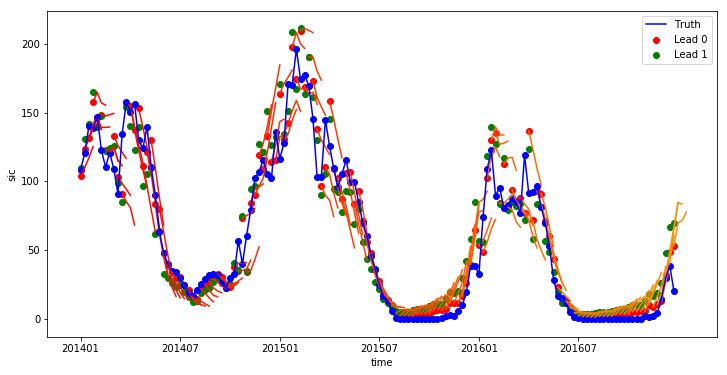

*******************  Predicted total OHC  **********************


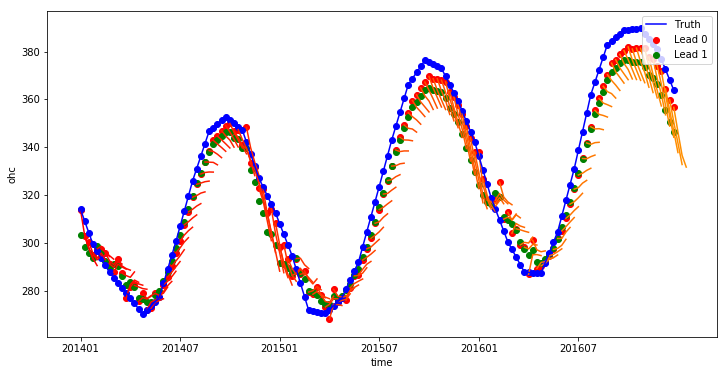

*******************  Loss with time  **********************
*******************  Prediction Ice Distribution  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


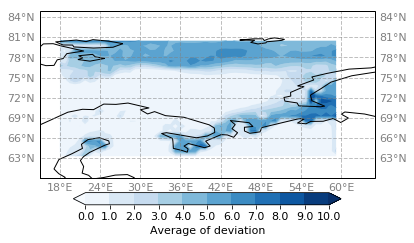

*******************  Other variables (Prediction with testing sets only) **********************


In [16]:
    #################################################################################
    ########        visualization of lead time dependent predictio           ########
    #################################################################################
    index_plot = np.arange(test_year*12*4)
    year_index = np.arange(2014,2017,1)
    # repeat climatology as reference
    #climatology = np.tile(seansonal_cycle_SIC,len(year_ERAI))
    # create index
    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    sic_extend_lead = np.sum(np.sum(lead_pred_sic,3),2)
    ohc_extend_lead = np.sum(np.sum(lead_pred_ohc,3),2)
    colormap=cm.autumn(range(test_year*12*4))
    fig0 = plt.figure(figsize=(12,6))
    for i in range(test_year*12*4):
        plt.plot(np.arange(index_plot[i],index_plot[i]+step_lead), sic_extend_lead[i,:], color=colormap[i])
    plt.scatter(index_plot, sic_extend_lead[:,0], color='r', label="Lead 0")
    plt.scatter(index_plot, sic_extend_lead[:,1], color='g', label="Lead 1")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1), 'b', label="Truth")
    plt.scatter(index_plot,np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1),color='b')
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('time')
    plt.ylabel('sic')
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201401', '201407',  '201501', '201507', '201601', '201607']))
    plt.legend(loc=1)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_lead.png'),dpi=300)
    print ("*******************  Predicted total OHC  **********************")
    fig1 = plt.figure(figsize=(12,6))
    for i in range(test_year*12*4):
        plt.plot(np.arange(index_plot[i],index_plot[i]+step_lead), ohc_extend_lead[i,:], color=colormap[i])
    plt.scatter(index_plot, ohc_extend_lead[:,0], color='r', label="Lead 0")
    plt.scatter(index_plot, ohc_extend_lead[:,1], color='g', label="Lead 1")
    #plt.scatter(index_plot, ohc_extend_lead[:,2], color='m', label="Lead 2")
    plt.plot(index_plot, np.sum(np.sum(ohc_exp_norm[-test_year*12*4:,:,:],2),1), 'b',label="Truth")
    plt.scatter(index_plot,np.sum(np.sum(ohc_exp_norm[-test_year*12*4:,:,:],2),1), color='b')
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('time')
    plt.ylabel('ohc')
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201401', '201407',  '201501', '201507', '201601', '201607']))
    plt.legend(loc=1)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig1.savefig(os.path.join(output_path,'OHC_ERAI_LSTM_pred_lead.png'),dpi=300)    
    
    print ("*******************  Loss with time  **********************")
    
    print ("*******************  Prediction Ice Distribution  **********************")
    deviation_spatial = np.sum(RSE(lead_pred_sic[:,0,:,:],sic_exp_norm[-test_year*12*4:,:,:]),0)
    label = 'Average of deviation'
    ticks = [i for i in np.linspace(0,10.0,11)]
    p = None # no t-test
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   deviation_spatial, p, # np.ma.masked_where(mask,data_predict_sic[0,:,:])
                                   label, ticks, os.path.join(output_path,
                                   'spatial_sic_deviation_avg.png'), boundary='Barents',
                                   colormap='Blues')
    print ("*******************  Other variables (Prediction with testing sets only) **********************")

In [17]:
    #################################################################################
    ########           performance evaluation with other methods             ########
    #################################################################################
    sequence_len, height, width = sic_exp_norm.shape
    print('##############################################################')
    print('############   start prediction with climatology  ############')
    print('##############################################################')
    # compute climatology
    climatology = np.zeros((48, height, width),dtype=float)
    for i in range(48):
        climatology[i,:,:] = np.mean(sic_exp_norm[i::48,:,:],axis=0)
    # repeat this climatology and calculate the RMSE
    climatology_seq = np.tile(climatology,(test_year,1,1))
    RMSE_climatology = np.sum(RMSE(climatology_seq,sic_exp_norm[-test_year*12*4:,:,:]))
    print('##############################################################')
    print('############   start prediction with persistence  ############')
    print('##############################################################')
    RMSE_persist = np.sum(RMSE(sic_exp_norm[-test_year*12*4-1:-1,:,:],sic_exp_norm[-test_year*12*4:,:,:]))
    print('##############################################################')
    print('########   start prediction with linear regression   #########')
    print('##############################################################')
    
    print('##############################################################')
    print('############   evaluation and statistical matrix  ############')
    print('##############################################################')
    print("Total RMSE with testing data - ConvLSTM")
    RMSE_ConvLSTM = np.sum(RMSE(lead_pred_sic[:,0,:,:],sic_exp_norm[-test_year*12*4:,:,:]))
    print(RMSE_ConvLSTM)
    print("Total RMSE with testing data - Climatology")
    print(RMSE_climatology)
    print("Total RMSE with testing data - Persistence")
    print(RMSE_persist)

##############################################################
############   start prediction with climatology  ############
##############################################################
##############################################################
############   start prediction with persistence  ############
##############################################################
##############################################################
########   start prediction with linear regression   #########
##############################################################
##############################################################
############   evaluation and statistical matrix  ############
##############################################################
Total RMSE with testing data - ConvLSTM
37.168790513961376
Total RMSE with testing data - Climatology
91.71030007968923
Total RMSE with testing data - Persistence
31.710045599444705
